Predict climate of a country (use all stations beginning with country code)

Get data for all given stations
Find monthly means
Plot these

In [1]:
import json
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
from GHCND import *

2023-03-13 13:24:20.813331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 13:24:21.311453: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 13:24:22.035340: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 13:24:22.036133: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
f = open('data/stat_counts_tmax.txt')
data = json.load(f)

# find all stations with no data gaps
no_gaps_tmax = [k for k, v in data.items() if v == 0]
station = no_gaps_tmax[-1]
print(station)

USW00094823


In [3]:
ghn = GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

# Get list of station names
station_names = ghn.getStatKeyNames()

# get url for a given station index
fileName = f"{station}.dly"
print(f"Filename: {fileName}")
urlName = f"http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/{fileName}"
print(f"url name: {urlName}")

# copy station data from remote to local
destination = f"data/{fileName}"
print(f"destination: {destination}")
urllib.request.urlretrieve(urlName, destination)
station_data = ghn.processFile(destination)
print(ghn.getStation(station))

t_max = Variable(ghn.getVar(station_data, 'TMAX'), "max temp (degC)", ghn.stationDict[station].name)
dates = t_max.get_dates()
vals = t_max.get_vals()


Read 219 countries and codes
Read 991 stations with justGSN
Filename: USW00094823.dly
url name: http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/USW00094823.dly
destination: data/USW00094823.dly
USW00094823 is PITTSBURGH INTL AP, United States at 40.4847 -80.2144 366.7


Text(0.5, 1.0, 'Mean monthly maximum temperatures over 10 years')

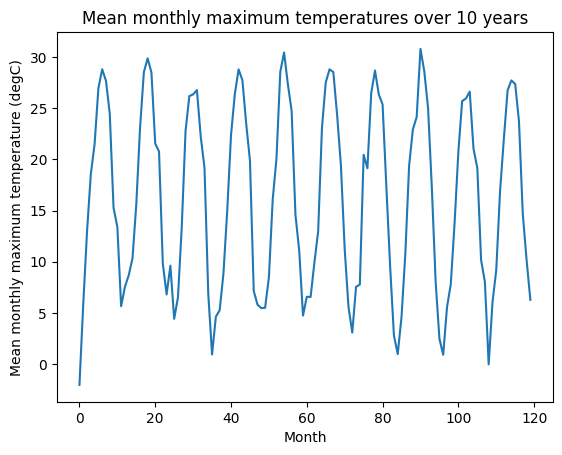

In [8]:
means = t_max.get_monthly_means()

fig, ax = plt.subplots()
ax.plot(means[:(12*10)])
ax.set_xlabel("Month")
ax.set_ylabel("Mean monthly maximum temperature (degC)")
ax.set_title("Mean monthly maximum temperatures over 10 years")